In [1]:
#![title](./img/log.png "ShowMyImage") 
#$\sum$

 Example Workflow

Apply Hashing: Use a hash function (e.g., MD5, SHA-1) to convert string categories into integer values.  
Map to Fixed Size: The resulting integer is then mapped to a fixed-size vector, often using modulo operation to ensure the vector size remains constant.  
Model Input: The resulting numeric vectors are used as inputs to machine learning model  



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

sns.set()
%matplotlib inline
pd.set_option('display.max_rows', 10)

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')
# Ignore all FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_data=pd.read_csv("./data/Simulated Customer Data.csv")
df_data.head()

,Gender,Country,SubscriptionType,Churn
0,Male,India,Premium,1
1,Female,Egypt,Free,0
2,Male,Egypt,Premium,1
3,Male,Egypt,Free,1
4,Male,Germany,Basic,0


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            1000 non-null   object
 1   Country           1000 non-null   object
 2   SubscriptionType  1000 non-null   object
 3   Churn             1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [5]:
df_data.describe()

,Churn
count,1000.000000
mean,0.514000
std,0.500054
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [20]:
cat_cols=df_data.select_dtypes(include='object').columns
target='Churn'


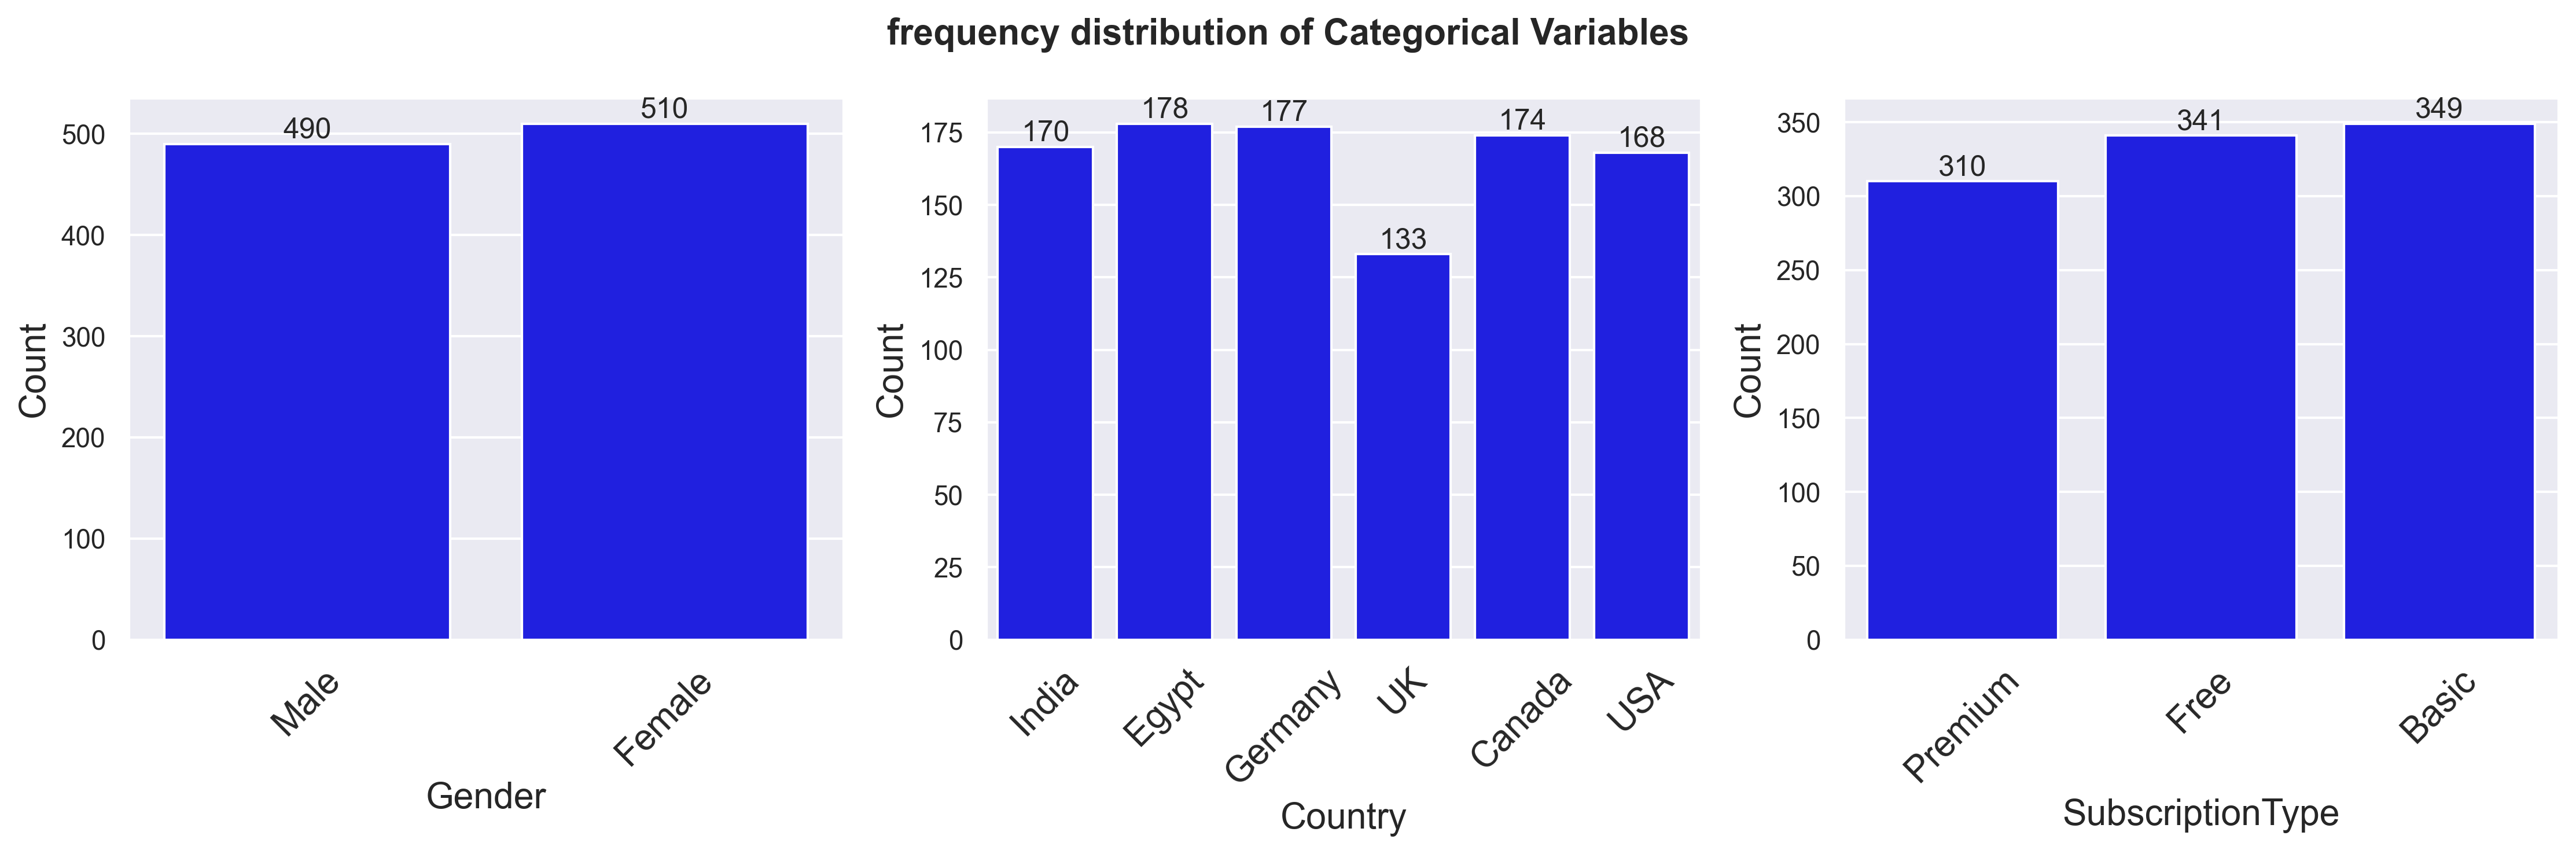

In [17]:
sns.set_style('darkgrid')
colors=['blue','red','green',]
custom_palette=sns.set_palette(sns.color_palette(colors))

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5),dpi=300)

for i, col in enumerate(cat_cols):
    graph = sns.countplot(data=df_data,x=col,ax=ax[i])
    ax[i].set_xlabel(col,fontsize=15)
    ax[i].set_ylabel('Count',fontsize=15)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=45,fontsize=15)
    
    for count in graph.containers:
        graph.bar_label(count)
    
plt.suptitle("frequency distribution of Categorical Variables",fontsize=15,fontweight='bold')
plt.tight_layout()
    
plt.show()

## Categorical Variables Encoding

## one hot encoding

In [18]:
df_data1=pd.get_dummies(df_data,cat_cols,drop_first=True,dtype=int)
df_data1.head()

,Churn,Gender_Male,Country_Egypt,Country_Germany,Country_India,Country_UK,Country_USA,SubscriptionType_Free,SubscriptionType_Premium
0,1,1,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,1,0
2,1,1,1,0,0,0,0,0,1
3,1,1,1,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0


### now lets see how the correlation looks

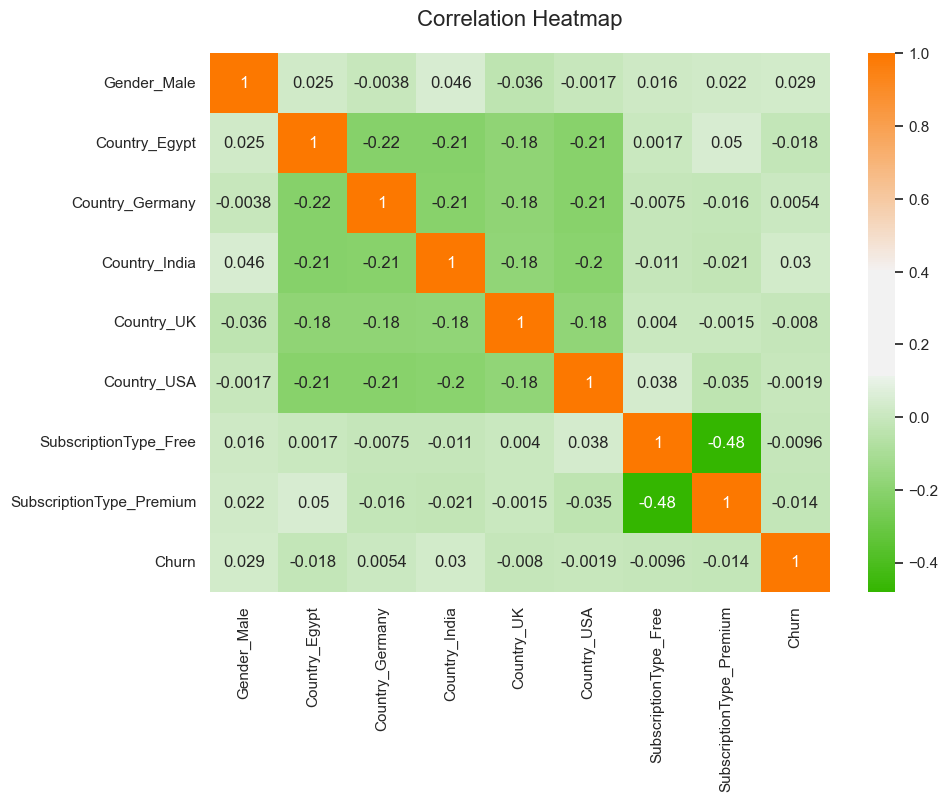

In [19]:

Cmap = sns.diverging_palette(125 ,28 ,s = 100 ,l = 65 ,sep = 50 ,as_cmap = True)
fig ,ax = plt.subplots(figsize = (10,7) ,dpi = 100)
ax = sns.heatmap(pd.concat([df_data1.drop(labels = target ,axis = 'columns') , df_data1[target]],axis = 'columns').corr() ,annot = True ,cmap = Cmap)
# drop target column as add and arrange it into last column ,which might be useful for readability.
plt.title('Correlation Heatmap', pad=20, fontsize=16)
plt.show()


## Enter hash encoding

Key Considerations for Choosing n_features  
1. Trade-off Between Dimensionality and Collision

Higher n_features:  
Reduces the likelihood of hash collisions (two different feature values mapping to the same bucket).  
Leads to a more accurate representation of the features.  
Increases computational and memory costs.  
Lower n_features:  
Saves memory and computation.  
Increases the chance of hash collisions, where different features are mapped to the same bucket, potentially introducing noise.  

2. Dataset Characteristics  

    Number of Unique Categories:  
        If you have many unique feature combinations, a higher n_features is necessary to avoid excessive collisions.  
        For example, if your combined features create 1,000 unique strings, setting n_features = 16 will likely result in significant collisions.  
    Size of Dataset:  
        For smaller datasets, lower values of n_features might suffice.  
        For larger datasets with diverse features, higher values are typically needed.  
        
3. Model Type  

    Tree-Based Models:  
        Robust to collisions, so you can use lower values for n_features.  
    Linear Models or Deep Learning:  
        Collisions may harm performance more significantly, necessitating a higher n_features.  

4.        





Guidelines for Choosing n_features  
1. Empirical Testing  

Start with a small value (e.g., n_features = 16 or 32) and gradually increase it, monitoring performance.  
Use tools like cross-validation to determine the optimal dimensionality.  

2. Rule of Thumb  

If the number of unique feature combinations is ( N ), a good starting point for n_features is slightly larger than ( \sqrt{N} ).  
For ( N = 1,000 ), try n_features = 32 or 64.  

3. Sparse Outputs  

If memory is a concern, keep the output of FeatureHasher as sparse (sparse=True) instead of converting it to dense arrays.  


In [23]:
#step 1 , define hash encoding with FeatureHasher , from sklearn.feature_extraction import FeatureHasher

for n_features in [8,16,32,64,128,256]:
    #num of buckets
    hasher = FeatureHasher(n_features=n_features,input_type='string')
    #combine categorical features into tuples
    combined_features = df_data[['Gender','Country','SubscriptionType']].apply(tuple,axis=1)

    '''
   If we combine category cols in one string ,that will return error because FeatureHasher needs an iterable of iterable structures (e.g., tuples or lists),
   and it will return series
   ex..df_data['combined'] = df_data['Gender'] + "_" + df_data['Country'] + "_" + df_data['SubscriptionType']  
   
   '''
    #now apply hash encoding
    hashed_features=hasher.transform(combined_features)
    hashed_features=hashed_features.toarray()

    '''
     If we have another Numerical cols ,we should concatenate them with hashed_features
     num_cols = df_data.select_dtypes(include = 'number')
     numerical_features = df_data[num_cols].values  # Convert numerical column to NumPy array
     
     X = np.hstack([hashed_features ,numerical_features])
     y = df_data['target']

     Then start train model ,but in this sate we not have a numerical cols
    '''
    
    X=hashed_features
    y=df_data[target]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    
    #defined classifer model, 
    GB_Classifier_Model = GradientBoostingClassifier(random_state=42)
    GB_Classifier_Model.fit(X_train,y_train)
    
    accuracy = GB_Classifier_Model.score(X_test,y_test)
    print(f' nn_features: {n_features} Accuracy: {accuracy}')
    
    y_pred = GB_Classifier_Model.predict(X_test)
    print('Classification Report:\n')
    print(classification_report(y_test,y_pred))
    

 nn_features: 8 Accuracy: 0.565
Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       104
           1       0.55      0.51      0.53        96

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

 nn_features: 16 Accuracy: 0.565
Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       104
           1       0.55      0.51      0.53        96

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

 nn_features: 32 Accuracy: 0.565
Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       104
           1       0.55      0.51      0.53        96

    accuracy